## testing model here

In [1]:
import gymnasium as gym
from gymnasium import spaces
import random
import pandas as pd
import numpy as np
import torch    # for loading LSTM models
from sklearn.preprocessing import MinMaxScaler
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
import random
from stable_baselines3.common.utils import get_schedule_fn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import torch
from torch import nn

class LSTMv1(nn.Module):
    def __init__(self, input_features, hidden_features, num_layers, output_features, device="cpu"):
        super().__init__()
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_features, hidden_features, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_features, output_features)
        self.to(device=device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_features, device=self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_features, device=self.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out[:, -1, :]


In [4]:
model_fundamental = LSTMv1(input_features=5, hidden_features=128, num_layers=3, output_features=5, device=device)
model_mavg = LSTMv1(input_features=2, hidden_features=128, num_layers=3, output_features=2, device=device)
model_mi = LSTMv1(input_features=4, hidden_features=128, num_layers=3, output_features=4, device=device)
model_adx = LSTMv1(input_features=1, hidden_features=128, num_layers=3, output_features=1, device=device)

In [5]:
## load saved models
model_fundamental.load_state_dict(torch.load("./models/model_fundamental.pth", weights_only=True, map_location=torch.device(device)))
model_mavg.load_state_dict(torch.load("./models/model_mavg.pth", weights_only=True, map_location=torch.device(device)))
model_mi.load_state_dict(torch.load("./models/model_mi.pth", weights_only=True, map_location=torch.device(device)))
model_adx.load_state_dict(torch.load("./models/model_adx.pth", weights_only=True, map_location=torch.device(device)))

<All keys matched successfully>

In [6]:
## hyper parameters
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 100000
INITIAL_ACCOUNT_BALANCE = 1000000

In [7]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, render_mode="human"):
        super().__init__()

        self.df = df
        self.render_mode = render_mode
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)

        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.rewards = []
        self.current_step = 0
        self.risk_free_rate = 0.00
        self.net_worth_log = []
        self.returns = []
        self.turbulence_threshold = 90
        self.trade_count = 0

        self.episode_sharpe_ratios = []
        self.episode_sortino_ratios = []

        sample_obs = self._next_observation()
        self.observation_space = spaces.Box(low=0, high=1, shape=sample_obs.shape, dtype=np.float32)

    def step(self, action):
        prev_net_worth = self.net_worth
        self._take_action(action)
        self.current_step += 1

        self.track_net_worth()

        terminated = (self.net_worth <= 0) or (self.current_step >= len(self.df))
        truncated  = (self.current_step >= MAX_STEPS)

        reward = (self.net_worth - prev_net_worth) / INITIAL_ACCOUNT_BALANCE
        drawdown = max(self.max_net_worth - self.net_worth, 0)
        reward -= drawdown / self.max_net_worth * 0.1

        self.rewards.append(reward)

        step_return = (self.net_worth - prev_net_worth) / prev_net_worth
        self.returns.append(step_return)

        info = {"net_worth_log": self.net_worth_log.copy()}

        if terminated or truncated:
            returns = np.array(self.returns)
            initial = INITIAL_ACCOUNT_BALANCE
            final = self.net_worth
            net_worth_log = self.net_worth_log

            sharpe = self._calculate_sharpe(returns)
            sortino = self._calculate_sortino(returns)
            cumulative_return = self._calculate_cumulative_return(net_worth_log)
            max_earning_rate = self._calculate_max_earning_rate(net_worth_log)
            max_drawdown = self._calculate_max_drawdown(returns)
            avg_profitability = self._calculate_average_profitability(returns)
            max_pullback = self._calculate_max_pullback(net_worth_log)
            avg_profit_per_trade = self._calculate_average_profitability_per_trade(initial, final, self.trade_count)

            info.update({
                "sharpe_ratio": sharpe,
                "sortino_ratio": sortino,
                "cumulative_return": cumulative_return,
                "max_earning_rate": max_earning_rate,
                "max_drawdown": max_drawdown,
                "average_profitability": avg_profitability,
                "max_pullback": max_pullback,
                "average_profitability_per_trade": avg_profit_per_trade,
                "net_worth_log": net_worth_log.copy()
            })

        obs = (
            self._next_observation()
            if not (terminated or truncated)
            else np.zeros(self.observation_space.shape, dtype=np.float32)
        )
        return obs, reward, terminated, truncated, info


    def _take_action(self, action):
        current_price = random.uniform(self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])
        if np.isnan(current_price) or current_price <= 0:
            current_price = 1e-6

        turbulence = self._compute_turbulence()

        if turbulence > self.turbulence_threshold:
            action_type = 1
            amount = 1.0
            self.trade_count += 1
            if self.render_mode == "human":
                print(f"[TURBULENCE OVERRIDE] Step {self.current_step}: Turbulence {turbulence:.4f} > Threshold {self.turbulence_threshold:.4f} → Forcing SELL ALL")
        else:
            action_type = int(np.clip(np.floor(action[0]), 0, 2))
            amount = float(np.clip(action[1], 0, 1))
            self.trade_count += 1

        if action_type < 1:
            total_possible = self.balance / current_price
            shares_bought = int(total_possible * amount)
            if shares_bought > 0:
                prev_cost = self.cost_basis * self.shares_held
                additional_cost = shares_bought * current_price
                if self.balance >= additional_cost:
                    self.balance -= additional_cost
                    self.shares_held += shares_bought
                    if self.shares_held > 0:
                        self.cost_basis = (prev_cost + additional_cost) / self.shares_held

        elif action_type < 2:
            shares_sold = int(self.shares_held * amount)
            shares_sold = min(shares_sold, self.shares_held)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.shares_held = max(0, self.shares_held)
        self.net_worth = self.balance + (self.shares_held * current_price)
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

        if self.shares_held == 0:
            self.cost_basis = 0

    def _next_observation(self):
        day_data = self.df.iloc[self.current_step]
        frame = np.array([
            day_data['Open'] / MAX_SHARE_PRICE,
            day_data['High'] / MAX_SHARE_PRICE,
            day_data['Low'] / MAX_SHARE_PRICE,
            day_data['Close'] / MAX_SHARE_PRICE,
            day_data['Volume'] / MAX_NUM_SHARES,
            day_data['EMA_12'] / MAX_SHARE_PRICE,
            day_data['EMA_26'] / MAX_SHARE_PRICE,
            day_data['MACD'] / 100,
            day_data['Signal'] / 100,
            day_data['RSI'] / 100,
            day_data['CCI'] / 200,
            day_data['ADX'] / 100,
            day_data['Sentiment Average'] / 1,
        ])

        attributes = np.array([
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ])

        fundamental_predictions, mavg_predictions, mi_predictions, adx_predictions = self._lstm_predictions()

        predictions = np.concatenate([
            fundamental_predictions, mavg_predictions, mi_predictions, adx_predictions
        ])

        obs = np.concatenate([frame, attributes, predictions])
        return obs

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.rewards = []
        self.net_worth_log = []
        self.returns = []

        self.track_net_worth()
        self.current_step = 0

        return self._next_observation(), {}

    def track_net_worth(self):
        if not hasattr(self, "net_worth_log"):
            self.net_worth_log = []
        self.net_worth_log.append(self.net_worth)

    def _lstm_predictions(self):
        fundamental_data = self.df.loc[self.current_step, ['Open', 'High', 'Low', 'Close', 'Volume']].values
        mavg_data = self.df.loc[self.current_step, ['EMA_12', 'EMA_26']].values
        mi_data = self.df.loc[self.current_step, ['MACD', 'Signal', 'RSI', 'CCI']].values
        adx_data = self.df.loc[self.current_step, ['ADX']].values

        fundamental_data = torch.tensor(fundamental_data.astype(np.float32), dtype=torch.float32, device=device).view(1, 1, -1)
        mavg_data = torch.tensor(mavg_data.astype(np.float32), dtype=torch.float32, device=device).view(1, 1, -1)
        mi_data = torch.tensor(mi_data.astype(np.float32), dtype=torch.float32, device=device).view(1, 1, -1)
        adx_data = torch.tensor(adx_data.astype(np.float32), dtype=torch.float32, device=device).view(1, 1, -1)

        fundamental_predictions = np.clip(model_fundamental(fundamental_data).detach().cpu().numpy().flatten(), -1, 1)
        mavg_predictions = np.clip(model_mavg(mavg_data).detach().cpu().numpy().flatten(), -1, 1)
        mi_predictions = np.clip(model_mi(mi_data).detach().cpu().numpy().flatten(), -1, 1)
        adx_predictions = np.clip(model_adx(adx_data).detach().cpu().numpy().flatten(), -1, 1)

        return fundamental_predictions, mavg_predictions, mi_predictions, adx_predictions

    def _compute_turbulence(self):
        features = ['Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']

        if self.current_step < 1:
            return 0

        try:
            current_data = self.df.iloc[self.current_step][features].values.reshape(1, -1)
            historical_data = self.df.iloc[:self.current_step][features].values

            if len(historical_data) < 2:
                return 0

            mean_vector = np.mean(historical_data, axis=0)
            cov_matrix = np.cov(historical_data, rowvar=False)
            cov_inv = np.linalg.pinv(cov_matrix)

            delta = current_data - mean_vector
            turbulence = np.dot(np.dot(delta, cov_inv), delta.T).item()
            return turbulence

        except Exception as e:
            print(f"Turbulence calculation error: {e}")
            return 0

    def _calculate_sharpe(self, returns, annualize=True):
        returns = np.array(returns)
        if len(returns) <= 1:
            return 0.0
        excess_returns = returns - (self.risk_free_rate / 252)
        mean = np.mean(excess_returns)
        std = np.std(excess_returns)
        if std < 1e-6:
            return 0.0
        sharpe = mean / std
        return sharpe * np.sqrt(252) if annualize else sharpe

    def _calculate_sortino(self, returns, annualize=True):
        returns = np.array(returns)
        if len(returns) <= 1:
            return 0.0
        downside_returns = returns[returns < (self.risk_free_rate / 252)]
        if len(downside_returns) == 0:
            return 0.0
        downside_std = np.std(downside_returns)
        if downside_std < 1e-6:
            return 0.0
        expected_return = np.mean(returns)
        sortino = (expected_return - (self.risk_free_rate / 252)) / downside_std
        return sortino * np.sqrt(252) if annualize else sortino

    def _calculate_cumulative_return(self, asset_values):
        if len(asset_values) < 2 or asset_values[0] == 0:
            return 0.0
        return ((asset_values[-1] - asset_values[0]) / asset_values[0]) * 100

    def _calculate_max_earning_rate(self, asset_values):
        asset_values = np.array(asset_values)
        if len(asset_values) < 2:
            return 0.0
        max_earning = max([
            (asset_values[i] - asset_values[j]) / asset_values[j]
            for i in range(len(asset_values))
            for j in range(i)
        ])
        return max_earning * 100

    def _calculate_max_drawdown(self, returns):
        if len(returns) == 0:
            return 0.0
        cumulative_returns = np.cumprod(1 + np.array(returns))
        peak = np.maximum.accumulate(cumulative_returns)
        drawdowns = (cumulative_returns - peak) / peak
        return np.min(drawdowns) * 100

    def _calculate_average_profitability(self, returns):
        if len(returns) == 0:
            return 0.0
        return np.mean(returns) * 100

    def _calculate_max_pullback(self, asset_values):
        if len(asset_values) < 2:
            return 0.0
        max_pullback = 0.0
        peak = asset_values[0]
        for value in asset_values:
            peak = max(peak, value)
            drawdown = (peak - value) / peak
            max_pullback = max(max_pullback, drawdown)
        return max_pullback * 100

    def _calculate_average_profitability_per_trade(self, initial_value, final_value, num_trades):
        if num_trades == 0:
            return 0.0
        return ((final_value - initial_value) / num_trades)


    def render(self, mode="human", close=False):
        mode = mode if mode is not None else self.render_mode
        if self.render_mode == "human":
            profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
            print(f'Step: {self.current_step}')
            print(f'Balance: {self.balance}')
            print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
            print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
            print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
            print(f'Profit: {profit}')
        elif self.render_mode == "rgb_array":
            return np.zeros((400, 600, 3), dtype=np.uint8)
        else:
            raise ValueError(f"Unsupported render mode: {self.render_mode}")


In [98]:
import os
path = "^DJI_test_data.csv"
df = pd.read_csv(path)
company_name = os.path.basename(path).split("_")[0]

In [110]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Load saved model
models_dir = "models/PPO"
model_path = f"{models_dir}/11000000.zip"

env = DummyVecEnv([lambda: StockTradingEnv(df=df, render_mode="human")])
env.seed(0)
env.reset()

model = PPO.load(model_path, env=env)

# Initialize lists to store results
results = {
    "sharpe_ratios": [],
    "sortino_ratios": [],
    "cumulative_returns": [],
    "max_earning_rates": [],
    "max_drawdowns": [],
    "average_profitabilities": [],
    "max_pullbacks": [],
    "average_profitabilities_per_trade": [],
    "net_worth_logs": [],
    "rewards": [],  # Track rewards per episode
}

episodes = 1

for ep in range(episodes):
    obs = env.reset()
    done = False
    episode_rewards = []

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward[0])
        env.render()

    info_dict = info[0]  # Unwrap from DummyVecEnv

    # Extract and save metrics
    results["sharpe_ratios"].append(info_dict.get("sharpe_ratio", 0.0))
    results["sortino_ratios"].append(info_dict.get("sortino_ratio", 0.0))
    results["cumulative_returns"].append(info_dict.get("cumulative_return", 0.0))
    results["max_earning_rates"].append(info_dict.get("max_earning_rate", 0.0))
    results["max_drawdowns"].append(info_dict.get("max_drawdown", 0.0))
    results["average_profitabilities"].append(info_dict.get("average_profitability", 0.0))
    results["max_pullbacks"].append(info_dict.get("max_pullback", 0.0))
    results["average_profitabilities_per_trade"].append(info_dict.get("average_profitability_per_trade", 0.0))
    results["net_worth_logs"].append(info_dict.get("net_worth_log", []))
    results["rewards"].append(episode_rewards)  # Store the rewards for this episode

    print(f"\nEpisode {ep + 1} finished")
    print(f"  Sharpe Ratio: {results['sharpe_ratios'][-1]:.4f}")
    print(f"  Sortino Ratio: {results['sortino_ratios'][-1]:.4f}")
    print(f"  Cumulative Return: {results['cumulative_returns'][-1]:.2f}%")
    print(f"  Max Earning Rate: {results['max_earning_rates'][-1]:.2f}%")
    print(f"  Max Drawdown: {results['max_drawdowns'][-1]:.2f}%")
    print(f"  Average Profitability: {results['average_profitabilities'][-1]:.2f}%")
    print(f"  Max Pullback: {results['max_pullbacks'][-1]:.2f}%")
    print(f"  Avg Profit per Trade: {results['average_profitabilities_per_trade'][-1]:.4f}")



Step: 1
Balance: 1000000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 1000000.0 (Max net worth: 1000000)
Profit: 0.0
Step: 2
Balance: 1000000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 1000000.0 (Max net worth: 1000000)
Profit: 0.0
Step: 3
Balance: 1000000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 1000000.0 (Max net worth: 1000000)
Profit: 0.0
Step: 4
Balance: 1000000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 1000000.0 (Max net worth: 1000000)
Profit: 0.0
Step: 5
Balance: 1000000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 1000000.0 (Max net worth: 1000000)
Profit: 0.0
[TURBULENCE OVERRIDE] Step 5: Turbulence 118.0665 > Threshold 90.0000 → Forcing SELL ALL
Step: 6
Balance: 1000000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 

In [111]:
# Plot net worth over episodes using Plotly
import plotly.graph_objects as go

fig = go.Figure()

# Loop through each episode's net worth log and plot
for i, episode_log in enumerate(results["net_worth_logs"]):
    fig.add_trace(go.Scatter(
        x=list(range(len(episode_log))),  # X-axis represents steps in each episode
        y=episode_log,                    # Y-axis represents net worth
        mode='lines',
        name=f'Episode {i+1}'             # Name for the legend, denoting the episode number
    ))

fig.update_layout(
    title=f'Net Worth Over Episodes',    # Set the plot title
    xaxis_title='Steps',                 # Label for the X-axis (steps)
    yaxis_title='Net Worth',             # Label for the Y-axis (net worth)
    template='plotly_dark'               # Optional: You can use a different template if you prefer
)

fig.show()


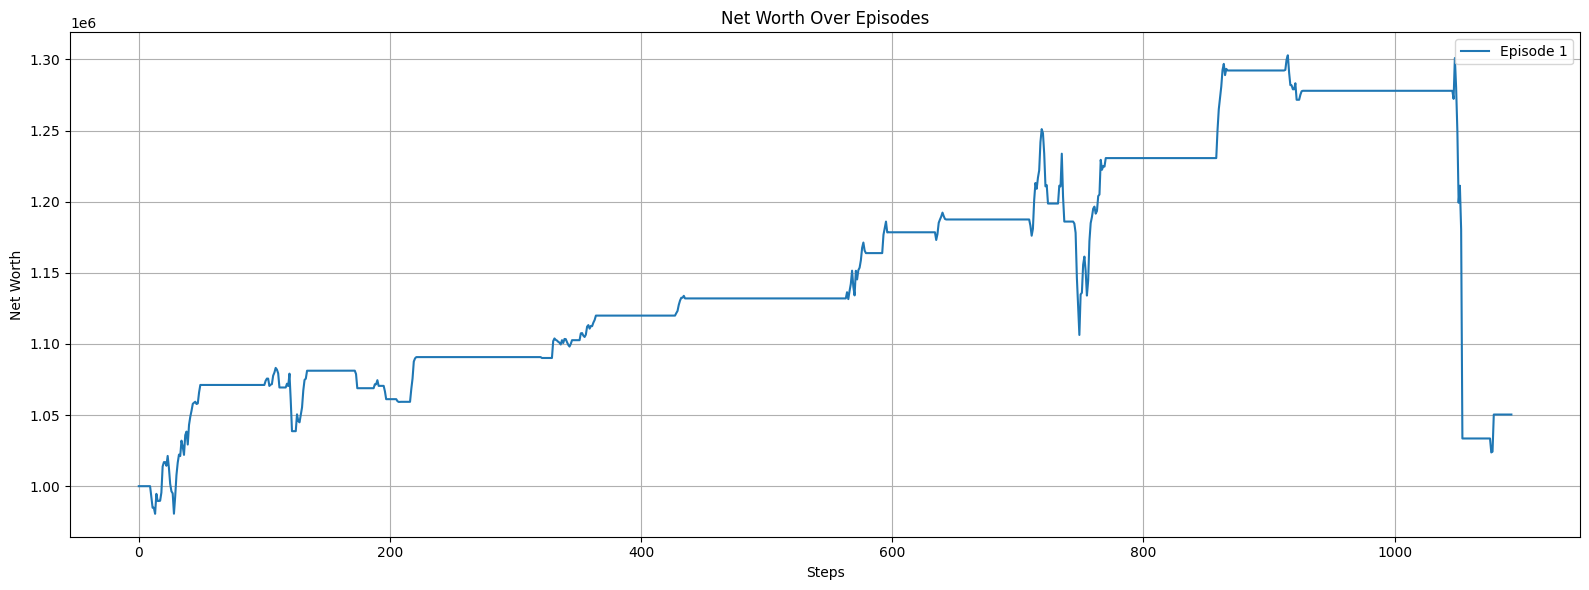

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Loop through each episode's net worth log and plot
for i, episode_log in enumerate(results["net_worth_logs"]):
    plt.plot(range(len(episode_log)), episode_log, label=f'Episode {i+1}')

plt.title(f'Net Worth Over Episodes')
plt.xlabel('Steps')
plt.ylabel('Net Worth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
x = np.mean(results['sharpe_ratios'])
x

np.float64(0.17527400591813097)

In [114]:
y = np.mean(results['sortino_ratios'])
y

np.float64(0.06814183653869153)

In [115]:
z = np.mean(results['cumulative_returns'])
z

np.float64(5.036886869468656)

In [116]:
p = np.mean(results['max_earning_rates'])
p

np.float64(32.87716407120982)

In [117]:
q = np.mean(results['max_pullbacks'])
q

np.float64(21.431713458992004)

In [118]:
r = np.mean(results['average_profitabilities_per_trade'])
r

np.float64(46.08313695762723)

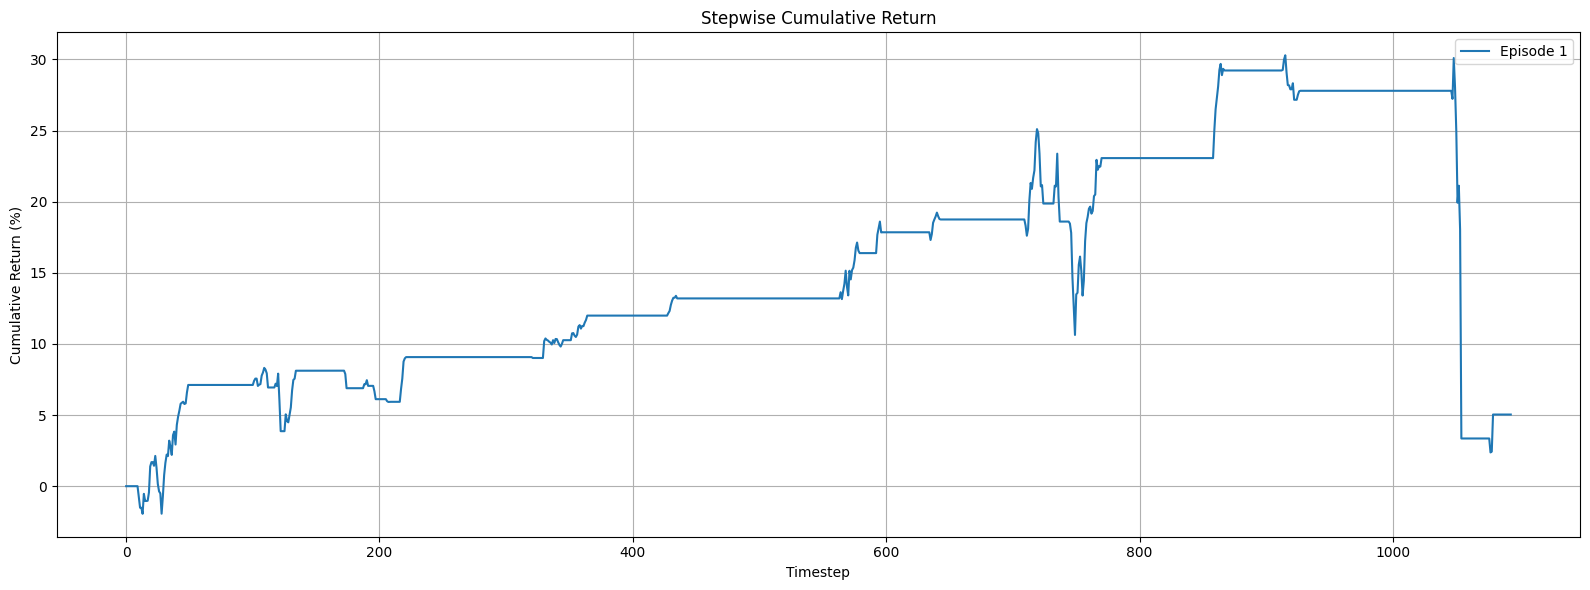

In [119]:
import matplotlib.pyplot as plt

# Initialize a list to store the cumulative returns for each episode
cumulative_return_logs = []

# Loop through each episode
for i, net_worth_log in enumerate(results["net_worth_logs"]):
    episode_cumulative_returns = []
    initial_net_worth = net_worth_log[0]  # Assuming the first value is the initial net worth

    # Calculate cumulative returns step by step for this episode
    for step, net_worth in enumerate(net_worth_log):
        cumulative_return = (net_worth - initial_net_worth) / initial_net_worth * 100
        episode_cumulative_returns.append(cumulative_return)

    # Store the cumulative returns for this episode
    cumulative_return_logs.append(episode_cumulative_returns)

# Plot the cumulative returns for each episode
plt.figure(figsize=(16, 6))

# Loop through each episode's cumulative return and plot
for i, returns in enumerate(cumulative_return_logs):
    plt.plot(returns, label=f"Episode {i+1}")

plt.title("Stepwise Cumulative Return")
plt.xlabel("Timestep")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


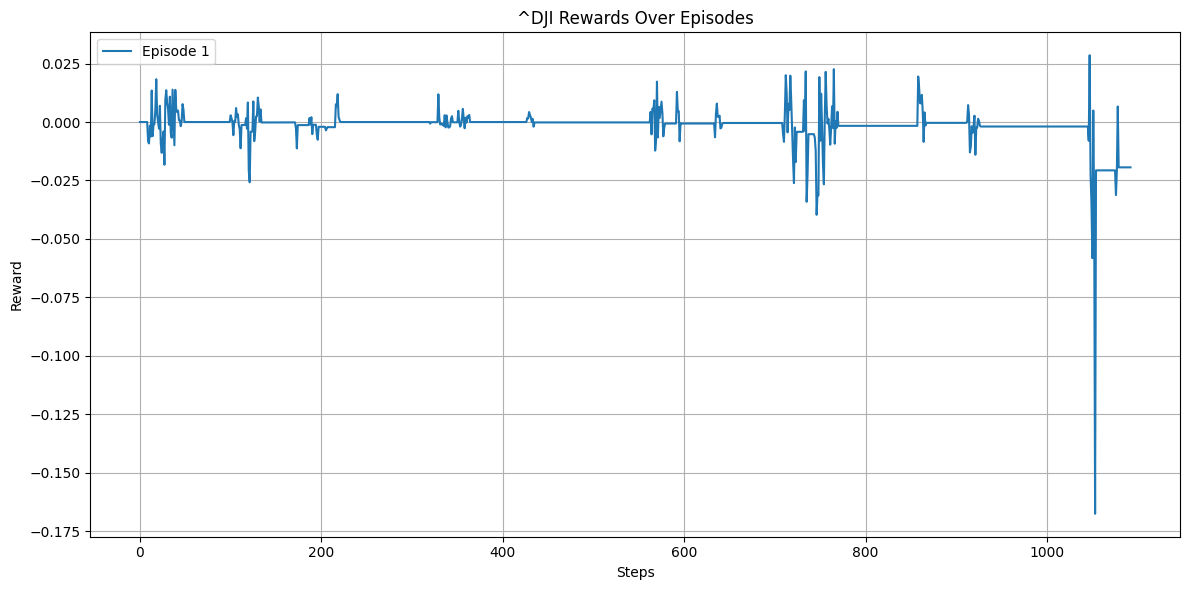

In [120]:
import matplotlib.pyplot as plt

# Initialize figure
plt.figure(figsize=(12, 6))

# Loop through each episode's rewards
for i, episode_rewards in enumerate(results["rewards"]):  # Correct key is 'rewards'
    # Plot rewards for each step in the episode
    plt.plot(range(len(episode_rewards)), episode_rewards, label=f'Episode {i+1}')

# Add plot details
plt.title(f'{company_name} Rewards Over Episodes')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
